In [57]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER

def pra_cmap(full=True,white=True):
    '''
    An alternative colormap
    '''
    newcmap=[
        (0.8313725490196079, 0.23921568627450981, 0.30980392156862746),
        (0.9529411764705882, 0.4196078431372549, 0.26666666666666666),
        (0.9921568627450981, 0.6666666666666666, 0.37254901960784315),
        (0.996078431372549, 0.8627450980392157, 0.5333333333333333),
        (1, 1,1),
        (0.9176470588235294, 0.9647058823529412, 0.6431372549019608),
        (0.7058823529411765, 0.8784313725490196, 0.6352941176470588),
        (0.4549019607843137, 0.6980392156862745, 0.7450980392156863),
        (0.25294117647058826, 0.38627450980392156, 0.7294117647058823)]

    n=4 if white else 5
    newcmap = mpl.colors.LinearSegmentedColormap.from_list('new_map',newcmap) if full else \
        mpl.colors.LinearSegmentedColormap.from_list('new_map',newcmap[n:])
    
    if full: 
        newcmap.set_under((0.6196078431372549,0.00392156862745098,0.25882352941176473))
    else:
        if white: newcmap.set_under((1,1, 1)) 
            
    newcmap.set_over((0.25098039215686274, 0.1803921568627451, 0.5019607843137255))
    return newcmap

# Load Kelvin data and example file contents

Contents are a subset of full file with 3 latitudes selected to save space 0; 8 and 16 and time subset to 
11/2018 - 12/2018

In [99]:
nc=xr.load_dataset('./wave_input/Kelvin_112018-122018_latsub_ERA5_6hr.nc')

In [100]:
nc

<xarray.Dataset>
Dimensions:              (time: 244, lat: 3, lon: 360)
Coordinates:
  * lat                  (lat) float64 0.0 8.0 16.0
  * lon                  (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time                 (time) datetime64[ns] 2018-11-01 ... 2018-12-31T18:0...
Data variables:
    eastward_wind        (time, lat, lon) float64 2.374 2.347 ... -0.07902
    geopotential_height  (time, lat, lon) float64 4.959 4.903 ... -0.1651
    divergence           (time, lat, lon) float64 -1.916e-07 ... -1.488e-07
Attributes:
    Conventions:  CF-1.5
    history:      Tue Nov  2 10:22:36 2021: ncks -C -O -x -v day_of_year uz_K...
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...

# Plot divergence for required times

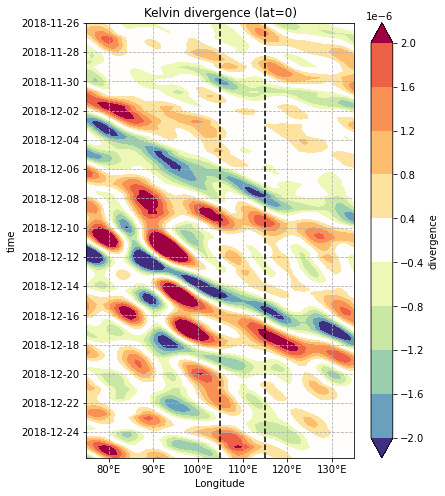

In [74]:
levels=np.arange(-2e-6,2.1e-6,4e-7)
levels=levels[~np.equal(levels,0)]
div_casestudy=nc.divergence.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime.datetime(2018,11,26),datetime.datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),ax=ax)
ax.set(title='Kelvin divergence (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)


# Repeat for R1, R2 and WMRG variables

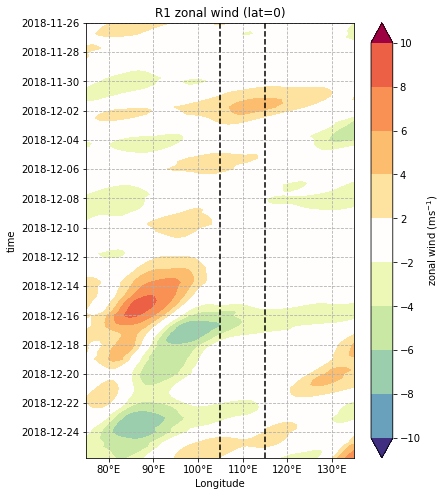

In [95]:
nc=xr.load_dataset('./wave_input/R1_112018-122018_latsub_ERA5_6hr.nc')
levels=np.arange(-10,11,2)
levels=levels[~np.equal(levels,0)]
div_casestudy=nc.eastward_wind.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime.datetime(2018,11,26),datetime.datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),extend='both',
                            ax=ax,cbar_kwargs={'label':r'zonal wind (ms$^{-1}$)'},'ticks':levels)
ax.set(title='R1 zonal wind (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)

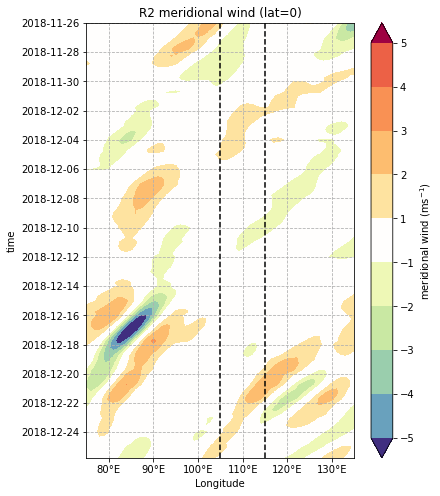

In [90]:
nc=xr.load_dataset('./wave_input/R2_112018-122018_latsub_ERA5_6hr.nc')
levels=np.arange(-5,6,1)
levels=levels[~np.equal(levels,0)]
div_casestudy=nc.nortward_wind.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime.datetime(2018,11,26),datetime.datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),extend='both',
                            ax=ax,cbar_kwargs={'label':r'meridional wind (ms$^{-1}$)'})
ax.set(title='R2 meridional wind (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)

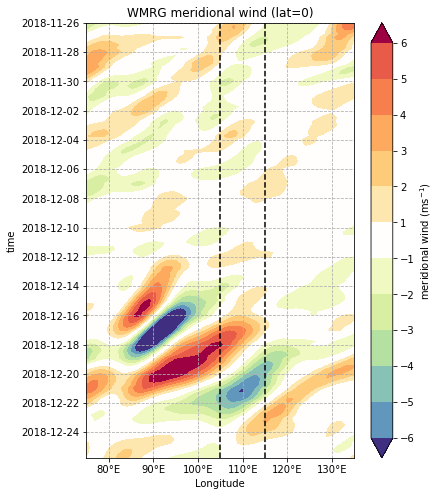

In [88]:
nc=xr.load_dataset('./wave_input/WMRG_112018-122018_latsub_ERA5_6hr.nc')
levels=np.arange(-6,7,1)
levels=levels[~np.equal(levels,0)]
div_casestudy=nc.nortward_wind.sel(lat=0,
                                lon=slice(75,135),
                                time=slice(datetime.datetime(2018,11,26),datetime.datetime(2018,12,25,18)))

fig,ax=plt.subplots(figsize=[6,8])
div_casestudy.plot.contourf(levels=levels,cmap=pra_cmap().reversed(),extend='both',
                            ax=ax,cbar_kwargs={'label':r'meridional wind (ms$^{-1}$)','ticks':levels})
ax.set(title='WMRG meridional wind (lat=0)',xlabel='Longitude')
ax.invert_yaxis()
ax.yaxis.set_major_locator(mpl.dates.DayLocator(interval=2))
ax.grid(linestyle='dashed')
[ax.axvline(x,color='k',linestyle='dashed') for x in [105,115]]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)